In [1]:
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from scipy import special
from scipy.stats import beta

In this notebook, we look at how the analytical distribution of class specific coverage changes depending on the amount of calibration data used.

*Note: By "analytical distribution," we mean the class coverage distribution computed using an infinite validation set* 

In [40]:
def get_analytical_class_cvg_distr(class_cts, alpha, grid=np.linspace(0, 1, 500)):

    distr = np.zeros(grid.shape)
    for k in range(len(class_cts)):
        a = np.ceil((class_cts[k] + 1) * (1 - alpha))
        b = class_cts[k] + 1 - a
        distr += beta.pdf(grid, a, b)
        
    distr /= len(class_cts)
    
    return distr

In [18]:
alpha = 0.1
num_classes = 1000

**Method 1**: For different dataset sizes, generate a random collection $C$ of class labels, chosen uniformly from $\{0,1,...,1000\}$. Then compute the analytical class coverage distribution that would result from using $C$ as our calibration set. 

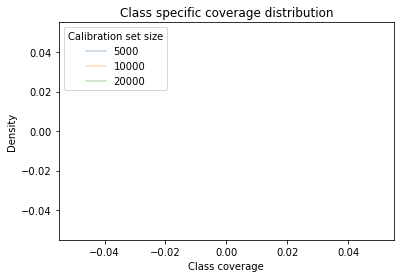

In [24]:
sizes = [5000, 10000, 20000]


grid = np.linspace(0, 1, 500)
for n in sizes:
    # Generate random labels
    calib_labels = np.random.choice(range(num_classes), size=(n,))
    
    # Count the number of instances of each class 
    class_cts = Counter(calib_labels)
    class_cts = [class_cts[i] for i in range(len(class_cts))]
    
    analytical_class_specific_cov_distr = get_analytical_class_cvg_distr(class_cts, alpha, grid=grid)
    plt.plot(grid, analytical_class_specific_cov_distr, label=n, alpha=0.3)
    
plt.xlabel('Class coverage')
plt.ylabel('Density')
plt.title('Class specific coverage distribution')
plt.legend(loc='upper left', title='Calibration set size')
plt.show()

Method 1 sometimes doesn't work due to the randomness in the data generation. When there is a class with 0 instances, the computed distribution is filled with nans. 

**Method 2**: For each $n$, generate a dataset $C$ of size $1000n$ that contains $n$ instances of each class. (More accurately, I set the class cts to $n$)

Desired coverage: 0.9
[n=10] Fraction of classes with coverage below 0.8: 0.108
[n=20] Fraction of classes with coverage below 0.8: 0.070
[n=50] Fraction of classes with coverage below 0.8: 0.019
[n=100] Fraction of classes with coverage below 0.8: 0.002
[n=200] Fraction of classes with coverage below 0.8: 0.000


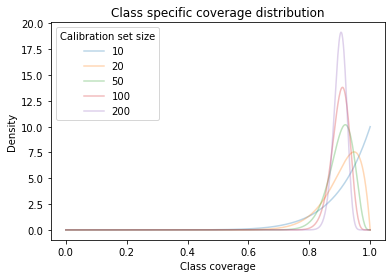

In [52]:
print(f'Desired coverage: {1-alpha}')

class_sizes = [10, 20, 50, 100, 200]


grid = np.linspace(0, 1, 500)
for n in class_sizes:
    # Generate random labels
    class_cts = n * np.ones((num_classes,))
    analytical_class_specific_cov_distr = get_analytical_class_cvg_distr(class_cts, alpha, grid=grid)
    print(f'[n={n}] Fraction of classes with coverage below 0.8: {analytical_class_specific_cov_distr[grid <= 0.8].sum() / len(grid):.3f}')
    plt.plot(grid, analytical_class_specific_cov_distr, label=n, alpha=0.3)
    
plt.xlabel('Class coverage')
plt.ylabel('Density')
plt.title('Class specific coverage distribution')
plt.legend(loc='upper left', title='Calibration set size')
plt.show()

With our empirical Bayes method, we hope to be able to be able to estimate the score cutoffs in a way that allows us to get a coverage distribution that is closely centered around 0.9 but without needing a large calibration set


**Update**: As Stephen pointed out, this is just plotting Beta distributions. Since there are an equal number of each class, we are averaging 1000 identical distributions, which just returns the original distribution.